# Imports

In [1]:
import sys
import os
# Get the parent directory
parent_folder = os.path.dirname(os.getcwd())
# add the parent directory to the Python path so that the scripts can be imported
sys.path.append(parent_folder)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from modules.capacity_estimation import capacity_estimation_base_load
from modules.capacity_estimation_sensitivity import sensitivity_analysis_irradiance_threshold
from modules.f_common_script import calc_percentage_error, calc_mean_percentage_error, calc_r2_score, plot_actual_vs_predicted, calc_error_factor

# Load data

In [3]:
f_name = '../data/nl/ams_data_merged_preprocessed.csv'
f_name_pv_capacity = '../data/nl/ams_pv_capacity_from_pv_profiles.csv'
df = pd.read_csv(f_name)
df_pv_capacity = pd.read_csv(f_name_pv_capacity)

In [4]:
# split the df_pv_capacity into part 1 and part 2, the first 10 household are part 1, the rest are part 2
df_pv_capacity_part1 = df_pv_capacity.drop(df_pv_capacity.index[10:])
df_pv_capacity_part2 = df_pv_capacity.drop(df_pv_capacity.index[:10])

In [5]:
f_name1 = '../data/nl/ams_data_merged_preprocessed_part1.csv'
df_part1 = pd.read_csv(f_name1)
f_name2 = '../data/nl/ams_data_merged_preprocessed_part2.csv'
df_part2 = pd.read_csv(f_name2)

In [6]:
# rename the first column of df_pv_capacity to 'household', second to 'capacity'
df_pv_capacity.rename(columns={
                      df_pv_capacity.columns[0]: 'household', df_pv_capacity.columns[1]: 'capacity'}, inplace=True)

In [7]:
df_pv_capacity_part1.rename(columns={
                            df_pv_capacity_part1.columns[0]: 'household', df_pv_capacity_part1.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part2.rename(columns={
                            df_pv_capacity_part2.columns[0]: 'household', df_pv_capacity_part2.columns[1]: 'capacity'}, inplace=True)

In [8]:
# drop the below columns for the following reasons:
# 9506H, because there is no solar panels.
# 4226R, because there is weird data in 2019 March.
# 7743P, for the high missing rate of 0.948231.
# 7099P, because none of its data is in summer.
# 3307S and 2108P, because they seem to have some demand response strategies.
households_to_remove = ['9506H', '4226R', '7743P', '7099P', '3307S', '2108P']
df_pv_capacity = df_pv_capacity[~df_pv_capacity['household'].isin(
    households_to_remove)]

In [9]:
# columns that ends with '_pv'
pv_cols = [col for col in df.columns if col.endswith('_pv')]
# columns that ends with '_con'
con_cols = [col for col in df.columns if col.endswith('_con')]
# columns that ends with '_net'
net_cols = [col for col in df.columns if col.endswith('_net')]

# Check the distribution of irradiance

This gives us a rough idea of the thresholds of irradiance to use.

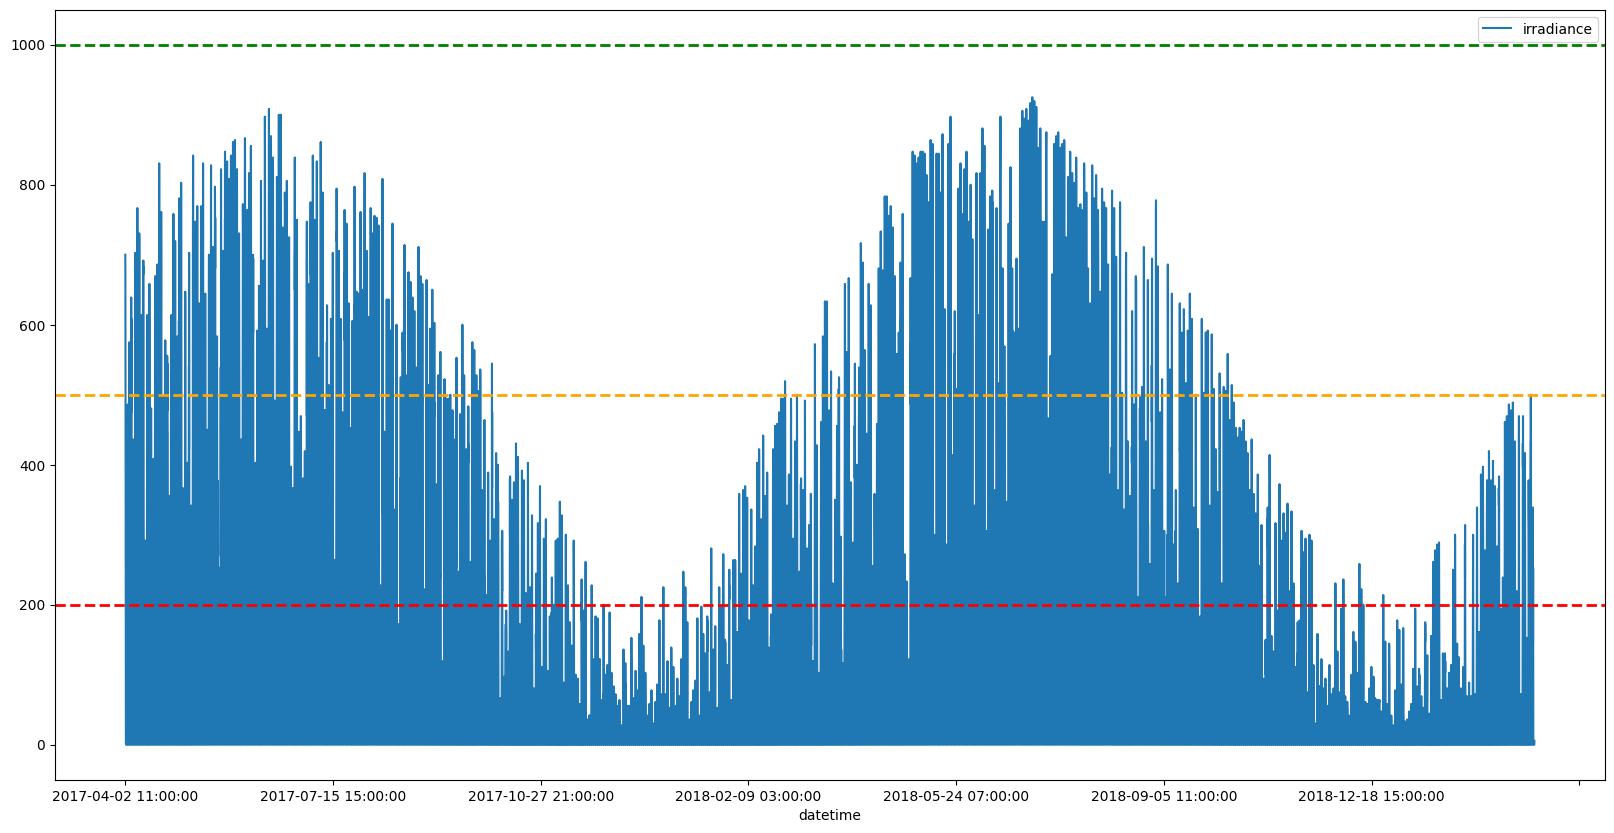

In [10]:
df_part1.plot(x='datetime', y='irradiance', figsize=(20, 10))
# draw a line where y=200
plt.axhline(y=200, color='red', linewidth=2, linestyle='--')
# draw a line where y=500
plt.axhline(y=500, color='orange', linewidth=2, linestyle='--')
# draw a line where y=1000
plt.axhline(y=1000, color='green', linewidth=2, linestyle='--')
plt.show()

# Capacity estimation based on base load

## Estimate the capacity for all households

Set the base_load_correction_factor to 1, since there is no historical data to calculate the correction factor.

In [11]:
# remove total_net and households to remove from net_cols
households_to_remove_with_suffix = [
    col + '_net' for col in households_to_remove]
net_cols_without_total_net = [col for col in net_cols if col !=
                              'total_net' and col not in households_to_remove_with_suffix]
# create an instance of capacity_estimation_base_load
cap_est_based_load = capacity_estimation_base_load(
    df, net_cols_without_total_net, base_load_correction_factor=1)
# estimate the capacity
capacity_based_load = cap_est_based_load.estimate_capacity()

In [12]:
capacity_based_load

1011W_net    2823.161755
1954W_net    2689.799410
1955A_net    2736.579766
1964J_net    2966.476239
2053G_net    3447.785026
2442E_net    1619.973333
3070L_net    2398.441618
3517V_net     732.923527
3660D_net    2786.203874
3726A_net    3218.803670
3932W_net    1006.592511
4451M_net    5621.090991
5427W_net    1424.390341
5815T_net    2885.878527
7426U_net     764.153599
7679U_net    2404.245831
7710F_net     909.281909
8319Q_net    2827.438312
9248C_net     939.249697
9370J_net    2576.076447
9991J_net    6753.452292
dtype: float64

In [13]:
# the length of capacity_based_load should be the same as df_pv_capacity
len(capacity_based_load)

21

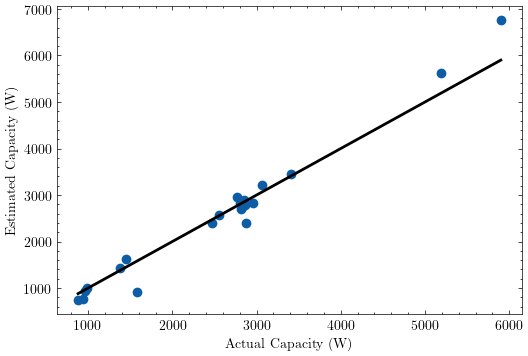

0.9475271825407134

In [14]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity.iloc[:, 1], capacity_based_load,
                         xlabel='Actual Capacity (W)', ylabel='Estimated Capacity (W)', trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity.iloc[:, 1], capacity_based_load)

From here, we can see that the capacity of other households are well estimated.

In [15]:
# sum up the capacity of all households both real and estimated
real_capacity = df_pv_capacity['capacity'].sum()
estimated_capacity = capacity_based_load.sum()
print(
    f'The real capacity is {real_capacity} W, and the estimated capacity is {estimated_capacity} W')
# print the error rate
capacity_error_rate = (
    real_capacity - estimated_capacity) / real_capacity * 100
print(f'The error rate is {capacity_error_rate}%')
error_factor = real_capacity/estimated_capacity
print(f'The error factor is {error_factor}')

The real capacity is 53504.32336904934 W, and the estimated capacity is 53531.99867354572 W
The error rate is -0.051725361155368625%
The error factor is 0.9994830138014247


# f for two parts

In [16]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col !=
                  'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part1 = [
    col for col in net_cols_part1 if col != 'total_net']
cap_est_based_load_part1_tmp = capacity_estimation_base_load(
    df_part1, net_cols_without_total_net_part1)
cap_est_based_load_part1_tmp.estimate_capacity()
base_load_correction_factor_from_part1 = cap_est_based_load_part1_tmp.base_load_correction_factor

In [17]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col !=
                  'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net_part2 = [
    col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2_tmp = capacity_estimation_base_load(
    df_part2, net_cols_without_total_net_part2)
cap_est_based_load_part2_tmp.estimate_capacity()
base_load_correction_factor_from_part2 = cap_est_based_load_part2_tmp.base_load_correction_factor

In [18]:
print(
    f'base_load_correction_factor_from_part2: {base_load_correction_factor_from_part2}')

base_load_correction_factor_from_part2: 1.0233585991896819


# Estimation for part 1

In [19]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_base_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col !=
                  'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [
    col for col in net_cols_part1 if col != 'total_net']

cap_est_based_load_part1 = capacity_estimation_base_load(
    df_part1, net_cols_without_total_net, base_load_correction_factor=base_load_correction_factor_from_part2)
# cap_est_based_load_part1 = capacity_estimation_base_load(df_part1,net_cols_without_total_net,base_load_correction_factor=1)
capacity_based_load_part1 = cap_est_based_load_part1.estimate_capacity()
capacity_based_load_part1

1011W_net    2832.826926
1954W_net    2702.341762
1955A_net    2747.832491
1964J_net    2986.575649
2053G_net    3461.853901
2442E_net    1636.837883
3070L_net    2407.952255
3517V_net     743.028715
3660D_net    2796.097767
3726A_net    3231.682075
dtype: float64

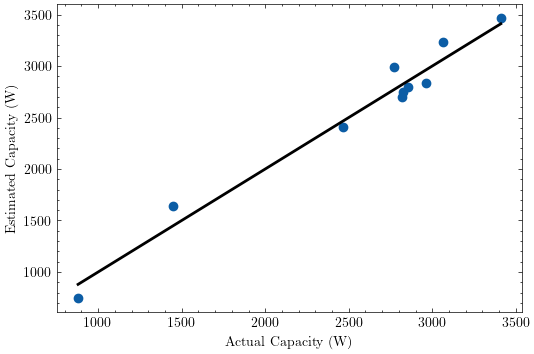

0.968002003553638

In [20]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1, fig_name='../figs/actual_vs_predicted_capacity_part1.pdf',
                         xlabel='Actual Capacity (W)', ylabel='Estimated Capacity (W)', trendline=False)
# calculate the R2 score
calc_r2_score(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1)

In [21]:
# sum up the capacity of all households both real and estimated
real_capacity_part1 = df_pv_capacity_part1['capacity'].to_numpy()
estimated_capacity_part1 = capacity_based_load_part1.to_numpy()
real_capacity_part1_sum = df_pv_capacity_part1['capacity'].sum()
estimated_capacity_part1_sum = capacity_based_load_part1.sum()
print(
    f'The real capacity is {real_capacity_part1_sum} W, and the estimated capacity is {estimated_capacity_part1_sum} W')
PE_part1 = calc_percentage_error(real_capacity_part1, estimated_capacity_part1)
print(f'The percentage error is {PE_part1}%')
MPE_part1 = calc_mean_percentage_error(
    real_capacity_part1, estimated_capacity_part1)
print(f'The mean percentage error is {MPE_part1}%')
R2_part1 = calc_r2_score(real_capacity_part1, estimated_capacity_part1)
print(f'The R2 score is {R2_part1}')
error_factor_part1 = calc_error_factor(
    real_capacity_part1_sum, estimated_capacity_part1_sum)
print(f'The error factor is {error_factor_part1}')

The real capacity is 25502.97063344348 W, and the estimated capacity is 25547.02942390774 W
The percentage error is -0.17275944476241928%
The mean percentage error is 0.33989328530910273%
The R2 score is 0.968002003553638
The error factor is 0.9982753849876953


## SA for part 1

In [22]:
df_part1_cleaned = df_part1.drop(columns=['1955A_pv', '1955A_net'])

In [23]:
# 3 levels of availability, 1 month (2018-06), 3 months(2018-06-2018-08), and 6 months(2018-06-2018-11)
df_part1_1month_summer = df_part1_cleaned[(
    df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-06-30')]
df_part1_1month_winter = df_part1_cleaned[(
    df_part1_cleaned['datetime'] >= '2018-12-01') & (df_part1_cleaned['datetime'] <= '2018-12-31')]
df_part1_3months = df_part1_cleaned[(
    df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-08-31')]
df_part1_6months = df_part1_cleaned[(
    df_part1_cleaned['datetime'] >= '2018-06-01') & (df_part1_cleaned['datetime'] <= '2018-11-30')]

In [24]:
df_pv_capacity_part1_cleaned = df_pv_capacity_part1[df_pv_capacity_part1['household'] != '1955A']

In [25]:
real_capacity_part1_cleaned = df_pv_capacity_part1_cleaned['capacity'].to_numpy(
)

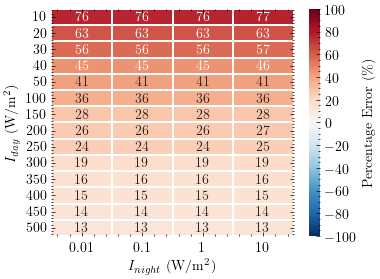

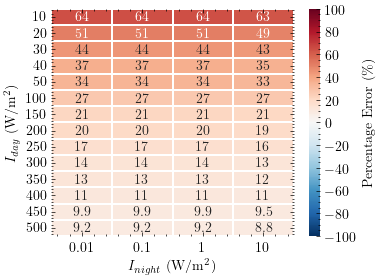

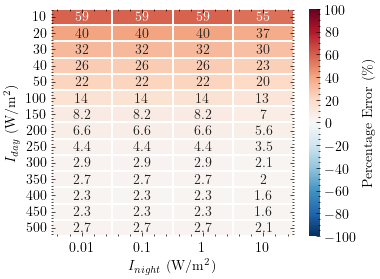

In [26]:
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer, real_capacity_part1_cleaned,
                                          fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_PE.pdf', base_load_correction_factor=base_load_correction_factor_from_part2, metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_3months, real_capacity_part1_cleaned, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_PE.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part2, metric='PE')
sensitivity_analysis_irradiance_threshold(df_part1_6months, real_capacity_part1_cleaned, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_PE.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part2, metric='PE')

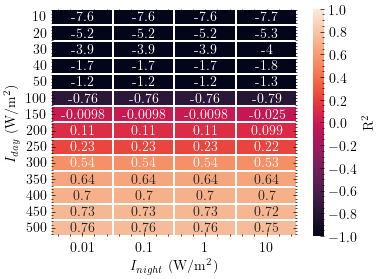

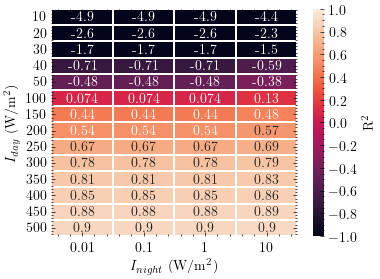

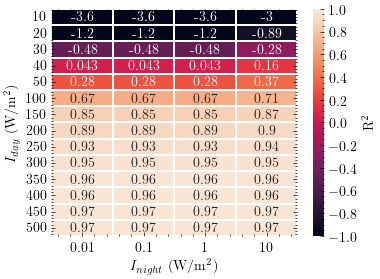

In [27]:
sensitivity_analysis_irradiance_threshold(df_part1_1month_summer, real_capacity_part1_cleaned,
                                          fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_1month_summer_r2.pdf', base_load_correction_factor=base_load_correction_factor_from_part2, metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_3months, real_capacity_part1_cleaned, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_3months_r2.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part2, metric='R2')
sensitivity_analysis_irradiance_threshold(df_part1_6months, real_capacity_part1_cleaned, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1_6months_r2.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part2, metric='R2')

# Estimation for part 2

In [28]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col !=
                  'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [
    col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2 = capacity_estimation_base_load(
    df_part2, net_cols_without_total_net, base_load_correction_factor=base_load_correction_factor_from_part1)
capacity_based_load_part2 = cap_est_based_load_part2.estimate_capacity()
capacity_based_load_part2

3932W_net    1000.017630
4451M_net    5567.843758
5427W_net    1416.096083
5815T_net    2861.991587
7426U_net     738.223242
7679U_net    2387.658439
7710F_net     877.040866
8319Q_net    2808.088266
9248C_net     927.158542
9370J_net    2562.952176
9991J_net    6687.379462
dtype: float64

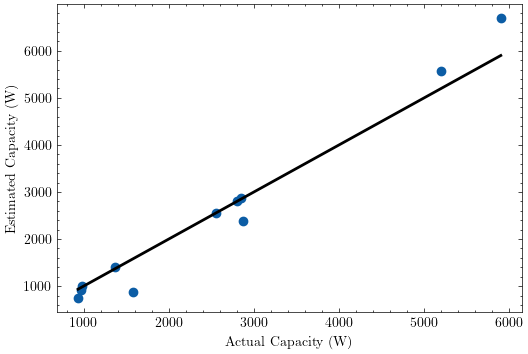

0.946302383659857

In [29]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2, fig_name='../figs/actual_vs_predicted_capacity_part2.pdf',
                         xlabel='Actual Capacity (W)', ylabel='Estimated Capacity (W)', trendline=False)
calc_r2_score(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2)

In [30]:
# sum up the capacity of all households both real and estimated
real_capacity_part2 = df_pv_capacity_part2['capacity'].sum()
estimated_capacity_part2 = capacity_based_load_part2.sum()
print(
    f'The real capacity is {real_capacity_part2} W, and the estimated capacity is {estimated_capacity_part2} W')
# print the error rate
capacity_error_rate_part2 = (
    real_capacity_part2 - estimated_capacity_part2) / real_capacity_part2 * 100
print(f'The error rate is {capacity_error_rate_part2}%')
error_factor_part2 = real_capacity_part2/estimated_capacity_part2
print(f'The error factor is {error_factor_part2}')

The real capacity is 28001.352735605855 W, and the estimated capacity is 27834.45005268077 W
The error rate is 0.5960522139805549%
The error factor is 1.0059962629981622


## SA for part 2

In [31]:
real_capacity_part2 = df_pv_capacity_part2['capacity'].to_numpy()

In [32]:
df_part2_1month_summer = df_part2[(
    df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-06-30')]
df_part2_1month_winter = df_part2[(
    df_part2['datetime'] >= '2018-12-01') & (df_part2['datetime'] <= '2018-12-31')]
df_part2_3months = df_part2[(
    df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-08-31')]
df_part2_6months = df_part2[(
    df_part2['datetime'] >= '2018-06-01') & (df_part2['datetime'] <= '2018-11-30')]

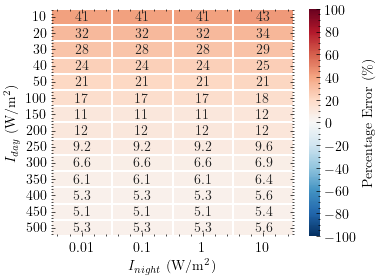

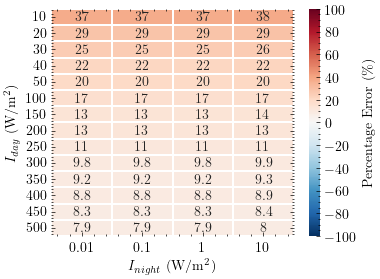

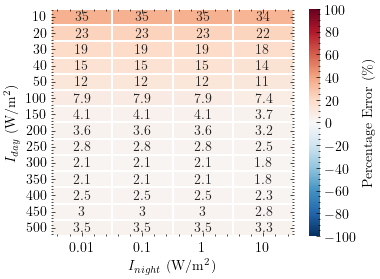

In [33]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_PE.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_3months, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_PE.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='PE')
sensitivity_analysis_irradiance_threshold(df_part2_6months, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_PE.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='PE')

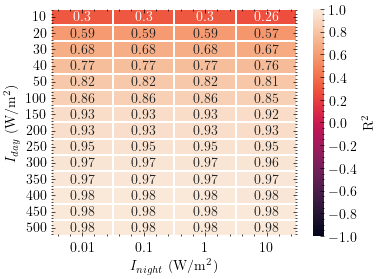

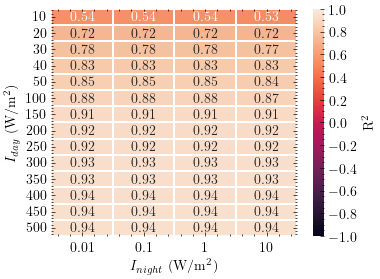

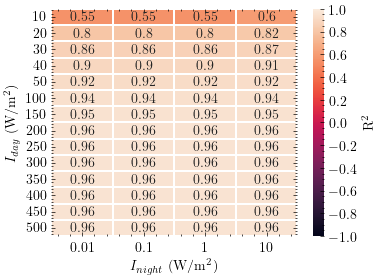

In [34]:
sensitivity_analysis_irradiance_threshold(df_part2_1month_summer, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_1month_summer_r2.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_3months, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_3months_r2.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='R2')
sensitivity_analysis_irradiance_threshold(df_part2_6months, real_capacity_part2, fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2_6months_r2.pdf',
                                          base_load_correction_factor=base_load_correction_factor_from_part1, metric='R2')